In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

from collections import Counter # for mAP

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

#from torchvision.ops import complete_box_iou_loss, distance_box_iou_loss

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'deeper_model_448x448/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED deeper. 448x448 images. 7x7 grid.')

# Folders

In [4]:
ds_dir = '../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


# Config

In [5]:
CLASSES = ["smoke", "fire"]

#IMG_DIM = {'W':88, 'H':88} # (W, H)
IMG_DIM = {'W':448, 'H':448} # (W, H)
IMG_W = IMG_DIM['W']
IMG_H = IMG_DIM['H']

SX = 7
SY = 7
B = 2 # Number of bounding boxes to predict.
C = len(CLASSES) # Number of classes in the dataset.

# Utils

In [6]:
def yolo2pixel(bbox):
    '''
    Transforms yolo coordinates of the box to pixel coordinates. 
    
    Arguments:
        - bbox: yolo coordinates [xc, yc, width, height]
    
    Returns: 
        - pixel coordinates [xmin, xmax, ymin, ymax]
    '''
    xc = bbox[0]
    yc = bbox[1]
    width = bbox[2]
    height = bbox[3]
      
    xmin = xc - (width/2)          
    xmax = xc + (width/2)         
    ymin = yc - (height/2)            
    ymax = yc + (height/2)
        
    nbox = [xmin, ymin, xmax, ymax]
    
    return nbox


def iou_tensor(
    boxes_preds, boxes_labels, 
    box_format="midpoint",
    epsilon=1e-6
):
    """
    Calculates intersection over union for bounding boxes.
    
    :param boxes_preds (tensor): Bounding box predictions of shape (BATCH_SIZE, 4)
    :param boxes_labels (tensor): Ground truth bounding box of shape (BATCH_SIZE, 4)
    :param box_format (str): midpoint/corners, if boxes (x,y,w,h) format or (x1,y1,x2,y2) format
    :param epsilon: Small value to prevent division by zero.
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] 
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    union = (box1_area + box2_area - intersection + epsilon)

    iou = intersection / union
    #print(f'IOU is numpy: {iou.numpy()}')

    return iou

def nms_yv1(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [x1, y1, x2, y2, confidence, class_id] MY FORMAT VERSION       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[4] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[5] != chosen_box[5]
            or iou_tensor(
                torch.tensor(chosen_box[:4]),
                torch.tensor(box[:4]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def nms_yv1_getBBoxes(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_id, score, xc, yc, w, h] Output of outcell_2_outboxes       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or iou_tensor(
                torch.tensor(chosen_box[2:6]),
                torch.tensor(box[2:6]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms



def mAP(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=2
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []
    avg_prec = {}

    # Precision and Recall for each class
    cls_prec = {}
    cls_rec = {}

    # used for numerical stability later on
    epsilon = 1e-6

    #for c in range(num_classes):
    for c in tqdm(range(num_classes), desc ="mAP:@.5"):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        
        #print(f'Detections of class {c}: {detections}')
        
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        
        #print(f'Amount bboxes of class {c}: {amount_bboxes}')

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        #print(f'Amount bboxes of class {c} converted: {amount_bboxes}')
        
        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
       
        #print(f'Total true bboxes of class {c}: {total_true_bboxes}')
        
        # If none exists for this class then we can safely skip
        # Maybe removing this is enough to take into account False Positives
        # for images with no objects
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = iou_tensor(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )
                # iou, _, _ = ut.iou(detection[3:], 
                #                    gt[3:]) 

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        #print(f'True Positives class {c}: {TP}')
        #print(f'False Positives class {c}: {FP}')

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        if precisions.numel() > 0:
            #cls_prec.update({c: precisions[-1].numpy()})
            cls_prec.update({c: precisions[-1].item()})
        else:
            cls_prec.update({c: 0.})
        if recalls.numel() > 0:
            #cls_rec.update({c: recalls[-1].numpy()})
            cls_rec.update({c: recalls[-1].item()})
        else:
            cls_rec.update({c: 0.})

        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))
        avg_prec.update({c: torch.trapz(precisions, recalls)})

        if c == 0:
            class_name = "smoke"
        elif c == 1:
            class_name = "fire"
        else:
            print("Wrong class")
            raise SystemExit("Wrong class in mAP")
        plt.plot(recalls, precisions)
        plt.scatter(recalls, precisions)
        plt.fill_between(recalls, precisions, alpha=0.1)
        plt.title("Precision-Recall Curve")
        plt.ylim([0,1])
        plt.xlim([0,1])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.grid()
        plt.savefig(log_path + class_name + "_pre_rec_curve.png")
        plt.close()

    mAP = sum(average_precisions) / (len(average_precisions) + epsilon)

    #return mAP, average_precisions, cls_prec, cls_rec
    return (mAP, 
            avg_prec,
            cls_prec, 
            cls_rec)


def get_bboxes(
    loader,
    model,
    SX,
    SY,
    B,
    C,
    mask,
    iou_threshold,
    threshold,
    device,
    box_format="midpoint"):
    
    
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    loop = tqdm(loader, desc='Get Boxes', leave=True)
    #for batch_idx, (imgs, labels, _, _) in enumerate(loader):
    #for batch_idx, (imgs, labels) in enumerate(loader):
    for batch_idx, (imgs, labels) in enumerate(loop):
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(imgs)

        batch_size = imgs.shape[0]
        true_bboxes = outcell_2_outboxes(out_cells=labels, 
                                         SX=SX, SY=SY, B=B, C=C, 
                                         mask=mask, 
                                         device='cpu', # Changed to cpu
                                         is_pred=False)
        bboxes = outcell_2_outboxes(out_cells=predictions, 
                                    SX=SX, SY=SY, B=B, C=C, 
                                    mask=mask, 
                                    device='cpu', # Changed to cpu
                                    is_pred=True)

        for idx in range(batch_size):
            #nms_boxes = nms_yv1(
            nms_boxes = nms_yv1_getBBoxes(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format, # Midpoint, to use iou_tensor inside
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred, as bboxes have Conf = 1 and the rest are 0
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def outcell_2_outboxes(out_cells, SX, SY, B, C, mask, device, is_pred = True):
    '''
    Convert batch of cells to batch of boxes: out_cells must be of shape (BATCH_SIZE, SX, SY, B*5+C) 
        [xcel, ycel, w, h, conf, class_0, class_1] -> [pred_class, score, xc, yc, w, h]
    
    Arguments:
        - out_cells: labels at loader output or predictions at model output
            Format: [xcel, ycel, w, h, conf, class_0, class_1]
    Return:
        - all_bboxes: list of bounding boxes
            Format: [[bboxes idx 0], [bboxes idx 1], ... [bboxes idx BATCH_SIZE-1]]
    '''

    out_cells = out_cells.to(device) # TAKE A LOOK TO CPU DECISION

    out_cells[out_cells <= 0] = 0 # Zeroing all negative values. Avoid (-conf * -class_id) = +score
    #out_cells[out_cells >= 1] = 1 # Clamping all values to 1. Avoid being out of the image. Maybe afterwards, although it does not hurt here.
                                   # This is due to yolo2pixel transformation, which could led to out of image values, depending on (w, h)

    batch_size = out_cells.shape[0]
    if is_pred:
        out_cells = out_cells.reshape(batch_size, SY, SX, B*5+C)
    else:
        out_cells = out_cells.reshape(batch_size, SY, SX, 5+C)
    
    # With 2 BBoxes, choose the one with highest confidence. How highest IOU, without label?
    if (B>1 and is_pred):
        '''
        2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
        '''
        bbox1 = out_cells[..., :4]
        bbox2 = out_cells[..., 5:9]
        score = torch.cat((out_cells[..., 4:5],out_cells[..., 9:10]), dim=-1)
        best_score, idx = torch.max(score, dim=-1, keepdim=True)

        bestbbox = (1-idx)*bbox1 + idx*bbox2

        #class_prob = a[..., 10:12] # Esto no hace falta, se hace debajo
        #cls_pred = class_prob.argmax(dim=-1, keepdim=True)
        out_cells = torch.cat((bestbbox, best_score, out_cells[..., 10:12]), dim=-1)
        
    
    # All cells are converted to boxes. Format will be [xc, yc, w, h, conf, class_0, class_1]
    boxes = cell2boxes(cells = out_cells, mask = mask)

    # ================================================================================================================== #
    #                                                                                                                    #
    #     Convert [xc, yc, w, h, conf, class_0, class_1] to [pred_class, score, xc, yc, w, h]                            #
    #         Identify class predicted: class_0 > class_1 ??? or the opposite                                            #
    #         Multiply (conf * class_id) to get score and compare to threshold afterwards. It will be 1 for ground truth #
    #                                                                                                                    #
    # ================================================================================================================== #
    classes = boxes[...,5:7].argmax(-1).unsqueeze(-1) # Indices of class predictes, matching class_id: index 0 -> smoke, class id = 0 // same for fire
    #print(f'Tensor of classes predicted\n {classes}')   
    
    # If SOFTMAX is used, there is no need to multiply conf * class_prob
    # scores = ( boxes[...,4].unsqueeze(-1) ) * boxes[...,5:7] # score = confidence * [class_0_prob, class_1_prob]
    # scores, _ = torch.max(scores, dim=-1, keepdim=True) # Get maximum values -> score of class predicted
    scores = boxes[..., 4:5]
    #print(f'Scores together\n {scores}')     
    
    out_boxes = torch.concat((classes, scores, boxes[...,:4]), dim=-1) # Concat all data
    #print(f'Final Output {out_boxes}')    

    # =========================================== #
    #                                             #
    #             Convert boxes to List           #
    #                                             #
    #    [[bboxes idx 0] , [bboxes idx 1], etc]   #
    #                                             #
    # =========================================== #
    all_bboxes = []

    for ex_idx in range(batch_size):
        bboxes = []

#         for bbox_i in range(SX):
#             for bbox_j in range(SY):
#                 bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_i, bbox_j, :]])
        for bbox_i in range(SX):
            for bbox_j in range(SY):
                bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_j, bbox_i, :]])     
        all_bboxes.append(bboxes)
    
    return all_bboxes


def cell2boxes(cells, mask):
    '''
    Converts cells to boxes using the cell2box_mask and broadcasting over batches
    In targets, sum only when score = 1

    Arguments:
        - cells: cells to convert, as yield by Dataloader in batches
        - mask: mask used for conversion

    Return:
        - cells converted to boxes
    '''

    #out_boxes = cells.clone().detach()
    out_boxes = cells.detach().clone()
    out_boxes[...,0:1] = (out_boxes[...,0:1] + mask[...,0:1])/SX 
    out_boxes[...,1:2] = (out_boxes[...,1:2] + mask[...,1:2])/SY 

    return out_boxes


def plot_preds(ori_img, img_w, img_h, nms_preds, names, colors):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''
    
    pic = ori_img.copy()
    
    for i,(xc,yc,w,h,score,class_id) in enumerate(nms_preds):
        box = np.array(yolo2pixel([xc,yc,w,h]))
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w
        box[3] = box[3]*img_h
        box = box.round().astype(np.int32).tolist()
        cls_id = int(class_id)
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic,box[:2],box[2:],color,2) # 1 -> rectangle thickness
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],thickness=1)  # 0.5 -> font size

    return pic

def save_log(epochs, 
             train_total_loss,
             train_box_loss,
             train_class_loss,
             train_confidence_loss,
             train_noobj_loss,
             train_mAP,
             train_class_AP,
             train_class_precision,
             train_class_recall,
             val_total_loss,
             val_box_loss,
             val_class_loss,
             val_confidence_loss,
             val_noobj_loss,
             val_mAP,
             val_class_AP,
             val_class_precision,
             val_class_recall,
             log_file_dst):
    
    '''
    Create a dictionary with all metrics
    Save the dictionary as excel file with Pandas
    '''
    
    epoch_range = range(epochs)
    log_file = {}
    log_file.update({"epoch": epoch_range})
    
    # Train Losses
    log_file.update({"train_total_loss": train_total_loss})
    log_file.update({"train_box_loss": train_box_loss})
    log_file.update({"train_class_loss": train_class_loss})
    log_file.update({"train_confidence_loss": train_confidence_loss})
    log_file.update({"train_noobj_loss": train_noobj_loss})
    
    # Train mAP, Class AP, Precision, Recall
    train_mAP_log = []
    for e in train_mAP:
        #train_mAP_log.append(e.numpy())
        #train_mAP_log.append(e)
        train_mAP_log.append(e.item())
    log_file.update({"train_mAP": train_mAP_log})
    
    train_smk_AP = []
    train_fire_AP = []
    for e in train_class_AP:
        #train_smk_AP.append(e[0].numpy())
        #train_smk_AP.append(e[0])
        train_smk_AP.append(e[0].item())
        #train_fire_AP.append(e[1].numpy())
        #train_fire_AP.append(e[1])
        train_fire_AP.append(e[1].item())
    log_file.update({"train_smk_AP": train_smk_AP})
    log_file.update({"train_fire_AP": train_fire_AP})
    
    
    train_smk_precision = []
    train_fire_precision = []
    for e in train_class_precision:
        #train_smk_precision.append(e[0].numpy())
        train_smk_precision.append(e[0])
        #train_fire_precision.append(e[1].numpy())
        train_fire_precision.append(e[1])
    log_file.update({"train_smk_precision": train_smk_precision})
    log_file.update({"train_fire_precision": train_fire_precision})
        
    train_smk_recall = []
    train_fire_recall = []
    for e in train_class_recall:
        #train_smk_recall.append(e[0].numpy())
        train_smk_recall.append(e[0])
        #train_fire_recall.append(e[1].numpy())
        train_fire_recall.append(e[1])
    log_file.update({"train_smk_recall": train_smk_recall})
    log_file.update({"train_fire_recall": train_fire_recall})
    
    # Validation Losses
    log_file.update({"val_total_loss": val_total_loss})
    log_file.update({"val_box_loss": val_box_loss})
    log_file.update({"val_class_loss": val_class_loss})
    log_file.update({"val_confidence_loss": val_confidence_loss})
    log_file.update({"val_noobj_loss": val_noobj_loss})
    
    # Val mAP, Class AP, Precision, Recall
    val_mAP_log = []
    for e in val_mAP:
        #val_mAP_log.append(e.numpy())
        val_mAP_log.append(e.item())
    log_file.update({"val_mAP": val_mAP_log})
    
    val_smk_AP = []
    val_fire_AP = []
    for e in val_class_AP:
        val_smk_AP.append(e[0].item())
        val_fire_AP.append(e[1].item())
    log_file.update({"val_smk_AP": val_smk_AP})
    log_file.update({"val_fire_AP": val_fire_AP})
    
    val_smk_precision = []
    val_fire_precision = []
    for e in val_class_precision:
        val_smk_precision.append(e[0])
        val_fire_precision.append(e[1])
    log_file.update({"val_smk_precision": val_smk_precision})
    log_file.update({"val_fire_precision": val_fire_precision})
    
    val_smk_recall = []
    val_fire_recall = []
    for e in val_class_recall:
        val_smk_recall.append(e[0])
        val_fire_recall.append(e[1])
    log_file.update({"val_smk_recall": val_smk_recall})
    log_file.update({"val_fire_recall": val_fire_recall})
    
    df = pd.DataFrame(log_file)
    df.to_excel(log_file_dst)

# Dataset

# DFire

In [7]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - max_obj:          maximum number of objects in the picture
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, 
                 num_imgs,
                 SX, SY, C, max_obj,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_imgs = num_imgs
        self.SX = SX
        self.SY = SY
        self.C = C
        self.max_obj = max_obj
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1)
                                ])

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )

        # Limit to n examples
        if self.num_imgs is not None:
            random.seed(123)
            random.shuffle(self.labels_list)       
            self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list[:self.num_imgs])
            self.num_samples = self.images.shape[0]
        else:
            self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)        
            self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xc, yc, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        xmin = xc - w/2
        ymin = yc - h/2
        xmax = xc + w/2
        ymax = yc + h/2
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
        more_than_x = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_mtx = np.zeros((self.SY, self.SX))
                overlapping_object = 0

                one_bboxes = []
                one_labels = []
            
                with open(label) as f:
                    lines = f.readlines()

                    # Restrict to max_obj boxes per sample
                    if len(lines) > self.max_obj:
                        more_than_x += 1
                        continue
                        
                    for line in lines:
                        class_id, x, y, w, h = line.strip().split()
                        class_id = int(class_id)
                        box = np.array([x, y, w, h]).astype(np.float32)
                        x, y, w, h = box[0], box[1], box[2], box[3]
                        box_ok = self.__bbox_check__([x, y, w, h])
                        x, y, w, h = box_ok[0], box_ok[1], box_ok[2], box_ok[3]
                        i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                        if label_mtx[i, j] == 1:
                            overlapping_object = 1
                            overlapping_rem += 1
                            #print(f'Removed {label} due to overlapping object in cell {i, j}')
                            break
                        else:
                            label_mtx[i, j] = 1
                            one_bboxes.append([x, y, w, h])
                            # smoke
                            if class_id == 0:
                                one_labels.append(0)
                            # fire
                            elif class_id == 1:
                                one_labels.append(1)
                            else:
                                print(f'File {label} errored in cell {i, j}')

                    if overlapping_object == 0:
                        # Padding to SX*SY labels and bounding boxes, so you can store tensors
                        # Label -1 indicates no box
                        for idx in range(self.SX*self.SY - len(one_labels)):
                            one_bboxes.append([0, 0, 0, 0])
                            one_labels.append(-1)
                        # print(f'\nBboxes and Labels of image {image_path}')
                        # print("Bboxes")
                        # for box in one_bboxes:
                        #     print(box)
                        # print("Labels")
                        # for label in one_labels:
                        #     print(label)
                        bboxes.append(one_bboxes)
                        labels.append(one_labels)
                        images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire Removed due to overlapping: {overlapping_rem}')
        print(f'DFire Removed due to more than {self.max_obj}: {more_than_x}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed due to overlapping: {overlapping_rem}')
        logger.info(f'DFire Removed due to more than {self.max_obj}: {more_than_x}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels

    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image'] 
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] 
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.0)
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# DFS

In [8]:
dfs_base_dir = '../../datasets/ds2fire/dfs_xml/'
dfs_images_dir = dfs_base_dir + 'images/'
dfs_labels_dir = dfs_base_dir + 'labels/'


# Get all txt file paths in path_annot and sort them
dfs_xml_files = sorted(
    [
        os.path.join(dfs_labels_dir, file_name)
        for file_name in os.listdir(dfs_labels_dir)
        if file_name.endswith(".xml")
    ]
)

dfs_len = len(dfs_xml_files)
dfs_train_elements = int(dfs_len*0.8)
dfs_test_elements = dfs_len - dfs_train_elements

random.seed(123)
random.shuffle(dfs_xml_files)
dfs_train_list = dfs_xml_files[:dfs_train_elements]
dfs_test_list = dfs_xml_files[dfs_train_elements:]

print(f'DFS number of samples: {dfs_len}')
print(f'DFS train samples: {len(dfs_train_list)}')
print(f'DFS test samples: {len(dfs_test_list)}')

DFS number of samples: 9462
DFS train samples: 7569
DFS test samples: 1893


In [9]:
class DFSDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - max_obj:          maximum number of objects in the picture
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, labels_list, 
                 SX, SY, C, max_obj,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.labels_list = labels_list
        self.SX = SX
        self.SY = SY
        self.C = C
        self.max_obj = max_obj
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                ])

        
        self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)
        
        self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
        more_than_x = 0
        
        
        for xml_file in labels_list:
#             fname = Path(xml_file).stem
#             image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
            
            tree = ET.parse(xml_file)
            root = tree.getroot()

            image_name = root.find("filename").text
            image_path = os.path.join(self.img_dir, image_name)
            #print(image_name, image_path)
            
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                overlapping_object = 0
                more_than_x_in = 0

                label_mtx = np.zeros((self.SY, self.SX))

                size = root.find("size")
                ori_img_w = float(size.find("width").text)
                ori_img_h = float(size.find("height").text)

                one_bboxes = []
                one_labels = []

                for obj in root.iter("object"):
                    class_name = obj.find("name").text
                    if class_name == 'smoke':
                        class_id = 0
                        more_than_x_in += 1
                    elif class_name == 'fire':
                        class_id = 1
                        more_than_x_in += 1
                    else:
                        continue 
                    bbox = obj.find("bndbox")
                    xmin = float(bbox.find("xmin").text)/ori_img_w
                    ymin = float(bbox.find("ymin").text)/ori_img_h
                    xmax = float(bbox.find("xmax").text)/ori_img_w
                    ymax = float(bbox.find("ymax").text)/ori_img_h

                    box = self.__bbox_check__([xmin, ymin, xmax, ymax])
                    #print(f'Class: {class_name} - Class_id: {class_id}. Coords: x={x}, y={y}, w={w}, h={h}')

                    x, y, w, h = box[0], box[1], box[2], box[3]
                    i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                    if label_mtx[i, j] == 1:
                        overlapping_object = 1
                        overlapping_rem += 1
                        break
                    else:
                        label_mtx[i, j] = 1
                        one_bboxes.append([x, y, w, h])
                        # smoke
                        if class_id == 0:
                            one_labels.append(0)
                        # fire
                        elif class_id == 1:
                            one_labels.append(1)
                        else:
                            print(f'File {label} errored in cell {i, j}') 
                
                if more_than_x_in > self.max_obj:
                    more_than_x += 1
                    continue
                
                if (overlapping_object == 0) and (more_than_x_in < (self.max_obj+1)):
                    # Padding to SX*SY labels and bounding boxes, so you can store tensors
                    # Label -1 indicates no box
                    for idx in range(self.SX*self.SY - len(one_labels)):
                        one_bboxes.append([0, 0, 0, 0])
                        one_labels.append(-1)
                    # print(f'\nBboxes and Labels of image {image_path}')
                    # print("Bboxes")
                    # for box in one_bboxes:
                    #     print(box)
                    # print("Labels")
                    # for label in one_labels:
                    #     print(label)
                    bboxes.append(one_bboxes)
                    labels.append(one_labels)
                    images.append(image_path)

        print(f'DFS Removed wrong images: {wrong_imgs}')
        print(f'DFS Removed due to overlapping: {overlapping_rem}')
        print(f'DFS Removed due to more than {self.max_obj}: {more_than_x}')
        logger.info(f'DFS Removed wrong images: {wrong_imgs}')
        logger.info(f'DFS Removed due to overlapping: {overlapping_rem}')
        logger.info(f'DFS Removed due to more than {self.max_obj}: {more_than_x}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels


 
    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image']
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] 
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.) 
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# Visualize some examples with a Test Train Loader

In [10]:
# view_dir = 'dfire4ex/train/'

# view_train_imgs = view_dir + 'images/'
# view_train_labels = view_dir + 'labels/'

In [11]:
VIEW_BATCH_SIZE = 32
VIEW_NUM_WORKERS = 1
VIEW_PIN_MEMORY = True

VIEW_S = 7
VIEW_C = 2
VIEW_B = 1
VIEW_MAX_OBJ = 10

VIEW_IMG_W = 448
VIEW_IMG_H = 448

# Data Aug Function

In [12]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        # If boxes are to close, it can remove some because they fall inside same cell
        A.RandomSizedBBoxSafeCrop(height=int(1.4*VIEW_IMG_H),
                                  width= int(1.4*VIEW_IMG_W),
                                  erosion_rate=0.3,
                                  p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
        ], p=0.9),
            # Shifting, scaling and rotation could dive 2 bbox inside same grid...
            #A.ShiftScaleRotate(rotate_limit=10, p=0.2),
        A.Resize(VIEW_IMG_H, VIEW_IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', 
                                min_area=16*16, 
                                min_visibility=0.1, 
                                label_fields=['class_labels']))

# DFS Dataset

In [13]:
logger.info('\nBefore View Dataset Examples')

view_dfs_dataset = DFSDataset(img_h = VIEW_IMG_H,
                              img_w = VIEW_IMG_W,
                              img_dir = dfs_images_dir,
                              labels_list = dfs_test_list,
                              SX = VIEW_S,
                              SY = VIEW_S,
                              C = VIEW_C,
                              max_obj = VIEW_MAX_OBJ,
                              transform=view_transform)

DFS Removed wrong images: 0
DFS Removed due to overlapping: 58
DFS Removed due to more than 10: 2


# View Loader

In [14]:
view_loader = DataLoader(dataset=view_dfs_dataset,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=VIEW_NUM_WORKERS,
                         pin_memory=VIEW_PIN_MEMORY,
                         shuffle=False,
                         drop_last=False)

# Utils to Plot

In [15]:
def get_bboxes_from_label_mtx(label_mtx):

    c2b_mtx = np.zeros((VIEW_S, VIEW_S, 2))
    for j in range(VIEW_S):
        for i in range(VIEW_S):
            c2b_mtx[i, j, 0] = j
            c2b_mtx[i, j, 1] = i

    label_mtx = label_mtx.numpy()
    label_xy = label_mtx[..., :2]
    label_rest = label_mtx[..., 2:]

    c2b_xy = (c2b_mtx+label_xy)/VIEW_S
    out = np.concatenate((c2b_xy, label_rest), axis=-1)
    #print(f'Concat out\n {out}')

    bboxes_list = np.reshape(out, (VIEW_S*VIEW_S, 5+VIEW_C))

    bboxes_list = [bbox for bbox in bboxes_list.tolist() if bbox[4]==1]

    return bboxes_list


def plot_pytorch(ds_img, img_w, img_h, nms_preds):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''

    names ={0: 'smoke', 1: 'fire'}
    colors = {'smoke': (0,255,255), 'fire': (255,255,0)}
    # NEVER remove copy() or use np.ascontiguousarray()
    pic = ds_img.numpy().copy()   

    for i,(xc,yc,w,h,score,smoke,fire) in enumerate(nms_preds):
        xmin, ymin, xmax, ymax = xc - w/2, yc - h/2, xc + w/2, yc + h/2
        box = np.array([xmin, ymin, xmax, ymax]).astype(np.float32)
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w-1 # avoid out of limits due to rounding
        box[3] = box[3]*img_h-1 # avoid out of limits due to rounding
        box = box.round().astype(np.int16).tolist()
        if smoke == 1:
            cls_id = 0
        elif fire == 1:
            cls_id = 1
        else:
            print("Error: no valid class")
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic, box[:2], box[2:], color, 3) 
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),
                    cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],
                    thickness=1)  # 0.5 -> font size

    return pic

# Plot

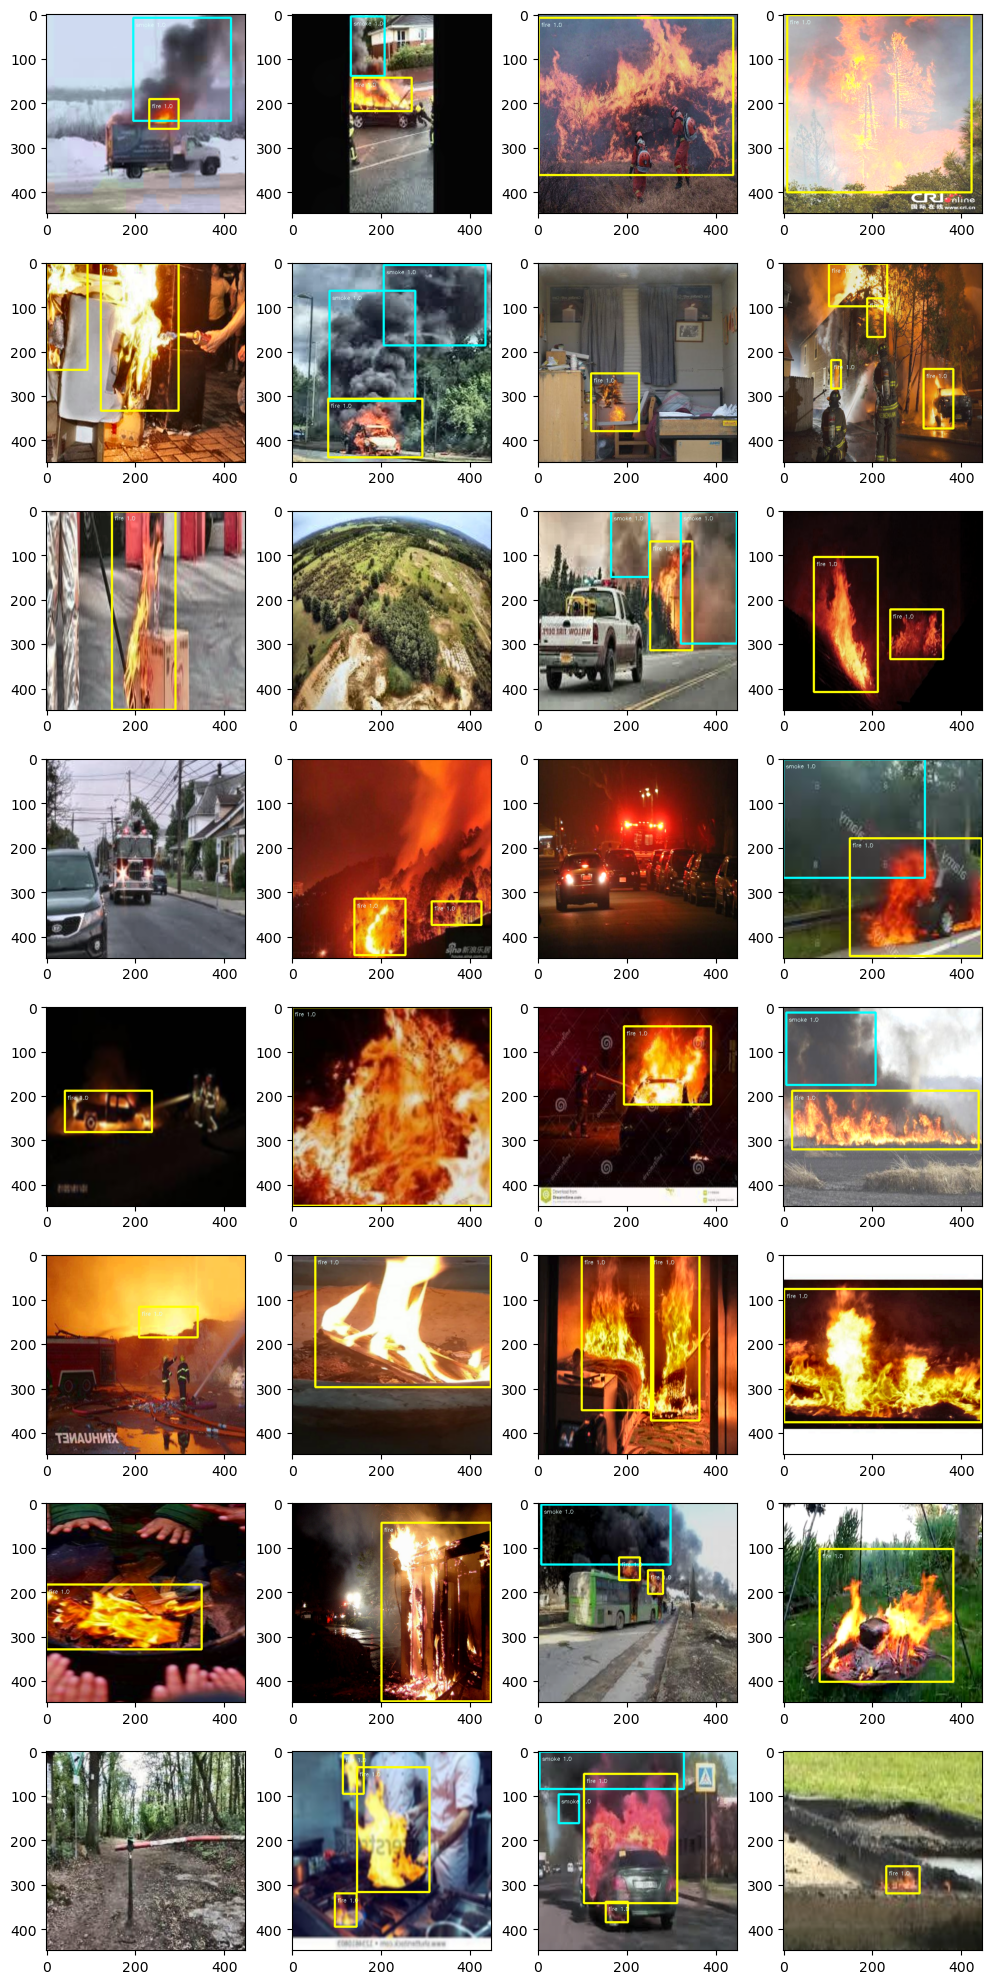

In [16]:
#for i, (img, label_mtx, img_path) in enumerate(view_loader):
for i, (img, label_mtx) in enumerate(view_loader):
    #print(f'Batch id = {i}')

    plt.subplots(8,4, figsize=(10, 20))

    for idx in range(VIEW_BATCH_SIZE):
        #print(f'Index inside batch = {idx}')
        #print(img_path[idx])
        bboxes = get_bboxes_from_label_mtx(label_mtx[idx])
        #print(bboxes)
        img_ds = plot_pytorch(img[idx].permute(1, 2, 0), 
                              VIEW_IMG_W, 
                              VIEW_IMG_H, 
                              bboxes)
        plt.subplot(8, 4, idx+1)
        plt.imshow(img_ds)
        #plt.imshow(img[idx].permute(1, 2, 0))
        
        if (idx == 31):
            break
    #if (idx == 1):
    plt.tight_layout()
    plt.show()
    break

# Classifier Model

In [17]:
class BED_448x448(nn.Module):
    def __init__(self, num_classes, S, B, in_channels=3):
        super(BED_448x448, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.S = S
        self.B = B
        
        self.model = self.__create_BED__()

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 448x448
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 224x224
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),

            # CNNBlock 7x7
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(256, affine=False),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(256, affine=False),
            nn.ReLU(),
            
            # CNNBlock Out
            nn.Conv2d(256, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, self.B*5 + self.num_classes, kernel_size=1, stride=1, padding=0,  bias=False),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    # [xc1, yc1, w1, h1, conf1, xc2, yc2, w2, h2, conf2, smoke, fire]
    # [0 ................. 4,    5 ................ 9      10    11 ]
    def forward(self, x):
        x_out = self.model(x)
        x = x_out.permute(0, 2, 3, 1)
        if self.B == 1:
            class_softmax = torch.softmax(x[..., 5:7], dim=-1)
            x = torch.cat((torch.sigmoid(x[..., 0:5]), class_softmax), dim=-1)  
        else:
            class_softmax = torch.softmax(x[..., 10:12], dim=-1)
            x = torch.cat((torch.sigmoid(x[..., 0:10]), class_softmax), dim=-1)
        return x 

# Yolo Loss 2BB

In [18]:
class YoloLossMSE_2BBox(nn.Module):
    '''
    Calculates Yolo V1 loss function, detailed in the paper

    Prediction format [xcell, ycell, w, h, confidence, class_0, class_1]
    Future update to 2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
    '''

    def __init__(self, SX, SY, B, C):
        super(YoloLossMSE_2BBox, self).__init__()
        
        self.mse = nn.MSELoss(reduction="sum")

        self.SX = SX
        self.SY = SY
        self.B = B
        self.C = C

        self.lambda_coord = 5
        self.lambda_noobj = 0.5
        self.lambda_conf = 1.5
              
        self.last_box_xy = 0.0
        self.last_box_wh = 0.0
        self.last_obj = 0.0
        self.last_noobj =0.0
        self.last_class = 0.0

    def forward(self, ground_truth, predictions):

        #predictions = predictions.reshape(-1, self.SY, self.SX, self.B*5 + self.C)
        assert predictions.shape == (BATCH_SIZE, self.SY, self.SX, self.B*5 + self.C) 
        assert ground_truth.shape == (BATCH_SIZE, self.SY, self.SX, 5 + self.C) 
        
        # =========================== #
        #        Exists Box?          #
        # =========================== #
        exists_box = ground_truth[..., 4:5] == 1
        pred_box1 = exists_box*predictions[..., 0:4]
        pred_box2 = exists_box*predictions[..., 5:9]
        target_box = exists_box*ground_truth[..., :4]

        # =========================== #
        #            IOU              #
        # =========================== #
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou1 = iou_tensor(boxes_preds=pred_box1, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 1\n{iou1}')
        iou2 = iou_tensor(boxes_preds=pred_box2, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 2\n{iou2}')
        ious = torch.cat([iou1, iou2], dim=-1)
        #print(f'IOUs\n{ious}')
        
        iou_maxes, best_boxes = torch.max(ious, keepdim=True, dim=-1)
        pred_boxes = best_boxes*pred_box2[..., :4]+(1-best_boxes)*pred_box1[..., :4]

        # =============== #
        #   Center Loss   #
        # =============== #
        xy_loss = self.mse(pred_boxes[..., :2],
                           target_box[..., :2])
        self.last_box_xy = xy_loss.item()
        #print('\nCenter Loss', center_loss)

        # ====================== #
        #   Width, Height Loss   #
        # ====================== #
        # Use torch.sign to undo torch.abs and preserve gradient sign 
        wh_loss = self.mse(torch.sign(pred_boxes[..., 2:4])*torch.sqrt(torch.abs(pred_boxes[..., 2:4])+1e-6),
                           torch.sqrt(target_box[..., 2:4]))
        #print(f'WH Loss {wh_loss:.6f}')
        self.last_box_wh = wh_loss.item()

        # =================== #
        #   Confidence Loss   #
        # =================== #
        conf_pred_box = exists_box*( best_boxes*predictions[..., 9:10] + (1-best_boxes) * predictions[..., 4:5])
        #print(f'Conf pred boxes \n {conf_pred_box}')
        # conf_loss = self.mse(conf_pred_box,
        #                      iou_maxes)
        conf_loss = self.mse(conf_pred_box,
                             exists_box*ground_truth[..., 4:5])
        #print(f'Conf loss {conf_loss:.6f}')
        self.last_obj = conf_loss.item()

        # ================== #
        #   No Object Loss   #
        # ================== #
        noobj_box1 = self.mse((~exists_box)*predictions[..., 4:5],
                              (~exists_box)*ground_truth[..., 4:5])
        noobj_box2 = self.mse((~exists_box)*predictions[..., 9:10],
                              (~exists_box)*ground_truth[..., 4:5])    
        noobj_loss = noobj_box1 + noobj_box2
        #print(f'No Obj loss {noobj_loss:.6f}')
        self.last_noobj = noobj_loss.item()

        # ======================= #
        #   Classification Loss   #
        # ======================= #
        class_loss = self.mse(exists_box*predictions[..., 10:12],
                              exists_box*ground_truth[..., 5:7]) 
        #print(f'Class Loss {class_loss:.6f}')
        self.last_class = class_loss.item()

        # ============== #
        #   Total Loss   #
        # ============== #
        total_loss = (
            self.lambda_coord*(xy_loss + wh_loss)
            + self.lambda_conf*conf_loss
            + self.lambda_noobj*noobj_loss 
            + class_loss
        )

        return total_loss

    def get_last_losses(self):     
        return (
            self.lambda_coord*self.last_box_xy,
            self.lambda_coord*self.last_box_wh,
            self.lambda_conf*self.last_obj,
            self.lambda_noobj*self.last_noobj,
            self.last_class
            )

# Train Loop Function

In [19]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, loss_l1_lambda, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)

        l1_lambda = loss_l1_lambda  # hyperparameter for L1 regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        train_loss = train_loss + l1_lambda * l1_norm
        
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # MSE Loss
        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        train_mean_loss.append(train_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)
        
    train_mean_loss_out = sum(train_mean_loss)/len(train_mean_loss)
    #print("\nTRAIN losses")
    logger.info("\nTRAIN losses")
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
                  "Box Loss".ljust(12) + "|" + 
                  "Conf Loss".ljust(12) + "|" + 
                  "No Obj Loss".ljust(12) + "|" + 
                  "Class Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12))
    logger.info(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_class_loss_out:.3f}'.ljust(12))
    
    return (train_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)

# Validation Loop Function

In [20]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)

        
        # MSE Loss
        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        val_mean_loss.append(val_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)
        
    val_mean_loss_out = sum(val_mean_loss)/len(val_mean_loss)
    #print("\nVAL losses")
    logger.info("\nVAL losses")
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12))

    logger.info("Total Loss".ljust(12) + "|" + 
                  "Box Loss".ljust(12) + "|" + 
                  "Conf Loss".ljust(12) + "|" + 
                  "No Obj Loss".ljust(12) + "|" + 
                  "Class Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12))
    logger.info(f'{val_mean_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_class_loss_out:.3f}'.ljust(12))
    
    return (val_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)

# Hyperparameters and Config

In [21]:
''' ============================
    Hyperparameters and More
============================ '''
MODEL = "BED"
#MODEL = "SQUEEZE"

LEARNING_RATE = 5e-4
#LEARNING_RATE = 1e-1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#BATCH_SIZE = 64 
BATCH_SIZE = 32 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 115
NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = log_path + "bed_best_2BB_mAP.pt"
PRETRAINED = False

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
EVAL_IMG_DIR = val_imgs
EVAL_LABEL_DIR = val_labels

TRAIN_MAX_OBJ = 3
TEST_MAX_OBJ = 3

LOSS_FN = "MSE"
L1_LAMBDA = 0.001 # Less regularization. From 0.001 to 0.0001

LOG_FILE = "log_file.xlsx"

IOU_mAP_THRES = 0.5
IOU_NMS_THRES = 0.5
THRESHOLD = 0.2

''' ============================
    Metrics
============================ '''
# mAP output
## Train
train_mAP = []
train_class_AP = []
train_class_precision = []
train_class_recall = []
## Val
val_mAP = []
val_class_AP = []
val_class_precision = []
val_class_recall = []

# Loss output
## Train
train_total_loss = []
train_box_loss = []
train_confidence_loss = []
train_noobj_loss = []
train_class_loss = []
## Val
val_total_loss = []
val_box_loss = []
val_confidence_loss = []
val_noobj_loss = []
val_class_loss = []

epochs_plot = []

# MODEL Setup

In [22]:
if MODEL == "BED":
    print("Using BED 4x4")
    logger.info("Using BED 4x4")
    model = BED_448x448(num_classes=C, S=SX, B=B).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(3, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test.shape}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test.shape}')
logger.info(f'BED Model Arquitecture\n{model}')   

optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.1, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED 4x4
Model shape is torch.Size([3, 7, 7, 12])
BED Model Arquitecture
BED_448x448(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1,

# Loss Function Setup

In [23]:
if B == 1:
    print(f'Using YoloLossMSE')
    logger.info(f'Using YoloLossMSE')
    loss_fn = YoloLossMSE(SX=SX, 
                          SY=SY, 
                          B=B, 
                          C=C)
elif B == 2:
    if LOSS_FN == "MSE":
        print(f'Using YoloLossMSE_2BBox')
        logger.info(f'Using YoloLossMSE_2BBox')
        loss_fn = YoloLossMSE_2BBox(SX=SX, 
                                    SY=SY, 
                                    B=B, 
                                    C=C)
    elif LOSS_FN == "DIOU":
        print(f'Using YoloLossDIOU_2BBox')
        logger.info(f'Using YoloLossDIOU_2BBox')
        loss_fn =YoloLossCIOU_2BBox(SX=SX, 
                                    SY=SY, 
                                    B=B, 
                                    C=C)
    else:
        raise SystemExit("Wrong Loss Function")
    print(f'L1 lambda: {L1_LAMBDA}')
    logger.info(f'L1 lambda: {L1_LAMBDA}')
else:
    print(f"Wrong B bounding boxes configuration: {B}")
    logger.info(f"Wrong B bounding boxes configuration: {B}")
    raise SystemExit("Wrong B bounding boxes configuration")

Using YoloLossMSE_2BBox
L1 lambda: 0.001


# Dataset and DataLoaders

In [24]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    # If boxes are to close, it can remove some because they fall inside same cell
    A.RandomSizedBBoxSafeCrop(height=int(1.4*IMG_H),
                              width= int(1.4*IMG_W),
                              erosion_rate=0.3,
                              p=0.3),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.4),
        A.HueSaturationValue(hue_shift_limit=10, p=0.2),
        A.Blur(blur_limit=(3,3), p=0.3),
        A.CLAHE(clip_limit=2.0, p=0.3),
    ], p=0.9),
        # Shifting, scaling and rotation could dive 2 bbox inside same grid...
        #A.ShiftScaleRotate(rotate_limit=10, p=0.2),
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
    ToTensorV2(p=1),
], bbox_params=A.BboxParams(format='yolo', 
                            min_area=16*16, 
                            min_visibility=0.1, 
                            label_fields=['class_labels']))
# TRAIN
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_imgs = None,
                             SX = SX,
                             SY = SY,
                             C = C,
                             max_obj = TRAIN_MAX_OBJ,
                             transform=train_transform)

print("TRAIN DFS dataset")
logger.info("TRAIN DFS dataset")
train_dfs_dataset = DFSDataset(img_h = IMG_H,
                               img_w = IMG_W,
                               img_dir = dfs_images_dir,
                               labels_list = dfs_train_list,
                               SX = SX,
                               SY = SY,
                               C = C,
                               max_obj = TRAIN_MAX_OBJ,
                               transform=train_transform)

print("Concatenate Train DFire and DFS datasets")
logger.info("Concatenate Train DFire and DFS datasets")
full_train_ds = torch.utils.data.ConcatDataset((train_dataset, train_dfs_dataset))
print(f'Train dataset len: {len(full_train_ds)}')
logger.info(f'Train dataset len: {len(full_train_ds)}')


# VALIDATION
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
eval_dataset = DFireDataset(img_h = IMG_H,
                            img_w = IMG_W,
                            img_dir = EVAL_IMG_DIR,
                            label_dir = EVAL_LABEL_DIR,
                            num_imgs = None,
                            SX = SX,
                            SY = SY,
                            C = C,
                            max_obj = TEST_MAX_OBJ,
                            transform=val_transform)
print("TEST DFS dataset")
logger.info("TEST DFS dataset")
test_dfs_dataset = DFSDataset(img_h = IMG_H,
                              img_w = IMG_W,
                              img_dir = dfs_images_dir,
                              labels_list = dfs_test_list,
                              SX = SX,
                              SY = SY,
                              C = C,
                              max_obj = TEST_MAX_OBJ,
                              transform=val_transform)

print("Concatenate Test DFire and DFS datasets")
logger.info("Concatenate Test DFire and DFS datasets")
full_test_ds = torch.utils.data.ConcatDataset((eval_dataset, test_dfs_dataset))
print(f'Test dataset len: {len(full_test_ds)}')
logger.info(f'Test dataset len: {len(full_test_ds)}')


# LOADERS
train_loader = DataLoader(dataset=full_train_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

eval_loader = DataLoader(dataset=full_test_ds,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         pin_memory=PIN_MEMORY,
                         shuffle=False,
                         drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire Removed due to overlapping: 546
DFire Removed due to more than 3: 1764
TRAIN DFS dataset
DFS Removed wrong images: 0
DFS Removed due to overlapping: 288
DFS Removed due to more than 3: 1231
Concatenate Train DFire and DFS datasets
Train dataset len: 21112

TEST DFire dataset
DFire Removed wrong images: 0
DFire Removed due to overlapping: 118
DFire Removed due to more than 3: 445
TEST DFS dataset
DFS Removed wrong images: 0
DFS Removed due to overlapping: 58
DFS Removed due to more than 3: 277
Concatenate Test DFire and DFS datasets
Test dataset len: 5330


# Main Function

In [25]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    print(f'SX: {SX}\nSY: {SY}\nB: {B}\nC: {C}')
    print(f'\nConfidence Threshold: {THRESHOLD}')
    print(f'IOU mAP Threshold: {IOU_mAP_THRES}')
    print(f'IOU NMS Threshold: {IOU_NMS_THRES}\n')
    print(f'Max Train Obj per image: {TRAIN_MAX_OBJ}')
    print(f'Max Test Obj per image: {TEST_MAX_OBJ}\n')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')
    logger.info(f'SX: {SX}\nSY: {SY}\nB: {B}\nC: {C}')
    logger.info(f'\nConfidence Threshold: {THRESHOLD}')
    logger.info(f'IOU mAP Threshold: {IOU_mAP_THRES}')
    logger.info(f'IOU NMS Threshold: {IOU_NMS_THRES}\n')
    logger.info(f'Max Train Obj per image: {TRAIN_MAX_OBJ}')
    logger.info(f'Max Test Obj per image: {TEST_MAX_OBJ}\n')

    ''' ============================
        Cell to Box Mask
    ============================ '''
    cell2box_mask = torch.zeros((SY, SX, 2))
    for i in range(SY):
        for j in range(SX):
            cell2box_mask[i,j,0] = j
            cell2box_mask[i,j,1] = i    

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_mAP = -1

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if PRETRAINED == True:
        print("Using a Pretrained Model")
        logger.info("Using a Pretrained Model")        
    elif LOAD_MODEL == False:
        print("Initializing Weights")
        logger.info("Initializing Weights")
        model._initialize_weights()
    else:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    #for epoch in range(EPOCHS):
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        t_loss, b_loss, conf_loss, n_loss, cls_loss = train_fn(loader=train_loader, 
                                                               model=model, 
                                                               optimizer=optimizer, 
                                                               loss_fn=loss_fn,
                                                               loss_l1_lambda=L1_LAMBDA,
                                                               device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(t_loss)
        train_box_loss.append(b_loss)
        train_confidence_loss.append(conf_loss)
        train_noobj_loss.append(n_loss)
        train_class_loss.append(cls_loss)
        

        # TRAIN MEAN AVERAGE PRECISION
        if ( (epoch+1) % 15 ) == 0:
            pred_boxes, target_boxes = get_bboxes(loader=train_loader, 
                                                  model=model,
                                                  SX=SX,
                                                  SY=SY,
                                                  B=B,
                                                  C=C,
                                                  mask=cell2box_mask,
                                                  iou_threshold=IOU_NMS_THRES, 
                                                  threshold=THRESHOLD,
                                                  device=DEVICE,
                                                  box_format="midpoint")

            mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                             true_boxes=target_boxes, 
                                                             iou_threshold=IOU_mAP_THRES, 
                                                             box_format="midpoint",
                                                             num_classes=C)

            train_mAP.append(mean_avg_prec)
            train_class_AP.append(avg_prec)   
            train_class_precision.append(cls_prec)
            train_class_recall.append(cls_rec)
            print(f"\nTrain mAP: {mean_avg_prec:.3f}")
            logger.info(f"\nTrain mAP: {mean_avg_prec:.3f}")
        
        # VALIDATING
        with torch.no_grad():
            v_loss, b_loss, conf_loss, n_loss, cls_loss = eval_fn(loader=eval_loader, 
                                                                  model=model,                         
                                                                  loss_fn=loss_fn,
                                                                  device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(v_loss)
            val_box_loss.append(b_loss)
            val_confidence_loss.append(conf_loss)
            val_noobj_loss.append(n_loss)
            val_class_loss.append(cls_loss)
            
            scheduler.step(v_loss)

            # VALIDATION MEAN AVERAGE PRECISION
            if ( (epoch+1) % 5 ) == 0:
                pred_boxes, target_boxes = get_bboxes(loader=eval_loader, 
                                                      model=model,
                                                      SX=SX,
                                                      SY=SY,
                                                      B=B,
                                                      C=C,
                                                      mask=cell2box_mask,
                                                      iou_threshold=IOU_NMS_THRES, 
                                                      threshold=THRESHOLD,
                                                      device=DEVICE,
                                                      box_format="midpoint")

                mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                                 true_boxes=target_boxes, 
                                                                 iou_threshold=IOU_mAP_THRES, 
                                                                 box_format="midpoint",
                                                                 num_classes=C)

                val_mAP.append(mean_avg_prec)
                val_class_AP.append(avg_prec)   
                val_class_precision.append(cls_prec)
                val_class_recall.append(cls_rec)
                print(f"\nValidation mAP: {mean_avg_prec:.3f}")
                logger.info(f"\nValidation mAP: {mean_avg_prec:.3f}")

                epochs_plot.append(epoch)
                plt.plot(epochs_plot, val_mAP, label="Val mAP")
                plt.title("Val mAP:@.50")
                plt.ylim([0,1])
                plt.xlabel("Epochs")
                plt.ylabel("mAP:@.50")
                plt.legend()
                plt.grid()
                plt.savefig(log_path + "Temp_bed_mAP.png")
                plt.close()

                if best_mAP < mean_avg_prec:
                    best_mAP = mean_avg_prec
                    print(f"\nSaving model with new best val mAP: {best_mAP:.3f}")
                    logger.info(f"\nSaving model with new best val mAP: {best_mAP:.3f}") 
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict()}, log_path + 'bed_best_2BB_mAP.pt') 

        if ( (epoch+1) % 5 ) == 0:
            torch.save(model.state_dict(), log_path + 'bed_2BB_5epoch.pt')
            
        if best_valid_loss > v_loss:
            best_valid_loss = v_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save(model.state_dict(), log_path + 'best_2BB.pt')     
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_2BB.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')

# Main Execute

In [26]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    #print(torch.cuda.is_available())
    main()

Starting script

Device: cuda
Learning Rate: 0.0005
Weight Decay: 0.0001
Batch Size: 32
IMG DIMS: (448, 448)
W: 448
H: 448
SX: 7
SY: 7
B: 2
C: 2

Confidence Threshold: 0.2
IOU mAP Threshold: 0.5
IOU NMS Threshold: 0.5

Max Train Obj per image: 3
Max Test Obj per image: 3


***Start Training: 11:46:00

Initializing Weights

=== EPOCH 0/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.62it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
197.229     |32.543      |25.356      |78.219      |8.820       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.87it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
73.558      |26.021      |30.693      |11.862      |4.983       

Saving model with new best validation loss: 73.558

=== EPOCH 1/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.760     |22.747      |30.936      |8.225       |4.503       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.92it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.167      |22.011      |29.079      |7.523       |3.553       

Saving model with new best validation loss: 62.167

=== EPOCH 2/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
88.405      |20.367      |30.669      |5.197       |3.610       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
57.196      |19.531      |30.201      |4.328       |3.136       

Saving model with new best validation loss: 57.196

=== EPOCH 3/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
81.597      |18.991      |29.919      |4.678       |3.290       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.528      |18.726      |28.483      |4.701       |2.618       

Saving model with new best validation loss: 54.528

=== EPOCH 4/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
77.147      |18.095      |28.998      |4.670       |3.075       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.84it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
53.111      |17.835      |26.894      |5.636       |2.746       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.63it/s]



Validation mAP: 0.084

Saving model with new best val mAP: 0.084

Saving model with new best validation loss: 53.111

=== EPOCH 5/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
74.337      |17.718      |28.540      |4.604       |2.902       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.83it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.437      |17.896      |26.922      |4.912       |2.707       

Saving model with new best validation loss: 52.437

=== EPOCH 6/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
72.170      |17.189      |28.206      |4.608       |2.828       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.84it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
51.479      |16.774      |28.072      |3.915       |2.718       

Saving model with new best validation loss: 51.479

=== EPOCH 7/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
70.375      |16.702      |27.735      |4.663       |2.725       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.87it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
50.548      |16.761      |27.127      |4.073       |2.587       

Saving model with new best validation loss: 50.548

=== EPOCH 8/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
68.834      |16.146      |27.496      |4.689       |2.706       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.84it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
49.505      |16.098      |27.020      |3.945       |2.442       

Saving model with new best validation loss: 49.505

=== EPOCH 9/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
67.563      |16.008      |27.076      |4.719       |2.609       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.88it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
48.403      |15.611      |26.826      |3.737       |2.229       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s]



Validation mAP: 0.155

Saving model with new best val mAP: 0.155

Saving model with new best validation loss: 48.403

=== EPOCH 10/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
66.617      |15.841      |26.630      |4.833       |2.480       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
47.856      |15.645      |26.106      |4.017       |2.088       

Saving model with new best validation loss: 47.856

=== EPOCH 11/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
65.230      |15.385      |26.033      |5.014       |2.388       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
47.628      |15.222      |23.033      |7.046       |2.327       

Saving model with new best validation loss: 47.628

=== EPOCH 12/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
64.560      |15.099      |25.800      |5.053       |2.395       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.82it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
46.442      |14.850      |24.655      |4.782       |2.155       

Saving model with new best validation loss: 46.442

=== EPOCH 13/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
63.747      |14.912      |25.453      |5.167       |2.283       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
46.947      |15.035      |24.671      |4.844       |2.397       

=== EPOCH 14/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
63.142      |14.716      |25.160      |5.219       |2.288       



mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:12<00:00,  6.05s/it]



Train mAP: 0.245


Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
46.009      |14.526      |22.539      |6.800       |2.144       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s]



Validation mAP: 0.222

Saving model with new best val mAP: 0.222

Saving model with new best validation loss: 46.009

=== EPOCH 15/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
62.220      |14.253      |24.689      |5.347       |2.316       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
45.221      |14.680      |22.293      |6.147       |2.101       

Saving model with new best validation loss: 45.221

=== EPOCH 16/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
61.570      |14.283      |24.291      |5.404       |2.170       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
44.483      |14.161      |22.958      |5.379       |1.985       

Saving model with new best validation loss: 44.483

=== EPOCH 17/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.619      |13.857      |23.782      |5.491       |2.139       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
43.886      |14.068      |22.837      |4.996       |1.985       

Saving model with new best validation loss: 43.886

=== EPOCH 18/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
60.526      |13.606      |23.736      |5.495       |2.172       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
43.253      |13.579      |22.375      |5.251       |2.049       

Saving model with new best validation loss: 43.253

=== EPOCH 19/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.848      |13.589      |23.407      |5.430       |2.136       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
42.139      |13.399      |20.943      |5.933       |1.864       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.51it/s]



Validation mAP: 0.227

Saving model with new best val mAP: 0.227

Saving model with new best validation loss: 42.139

=== EPOCH 20/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.219      |13.285      |23.136      |5.553       |2.102       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.62it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
43.806      |14.107      |21.074      |6.545       |2.079       

=== EPOCH 21/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
59.117      |13.203      |22.946      |5.653       |2.124       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
43.257      |13.496      |20.428      |7.170       |2.163       

=== EPOCH 22/114 ===
Learning Rate = 0.0005



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
58.646      |13.009      |22.947      |5.592       |2.026       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
42.245      |13.298      |21.926      |4.897       |2.124       

=== EPOCH 23/114 ===
Learning Rate = 0.0004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
56.781      |12.529      |22.191      |5.595       |1.937       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.688      |12.961      |19.588      |6.315       |1.825       

Saving model with new best validation loss: 40.688

=== EPOCH 24/114 ===
Learning Rate = 0.0004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
56.462      |12.436      |22.004      |5.643       |1.944       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.510      |12.791      |20.962      |4.976       |1.782       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.63it/s]



Validation mAP: 0.258

Saving model with new best val mAP: 0.258

Saving model with new best validation loss: 40.510

=== EPOCH 25/114 ===
Learning Rate = 0.0004



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
55.795      |12.428      |21.771      |5.624       |1.816       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.790      |12.560      |21.572      |4.659       |2.000       

=== EPOCH 26/114 ===
Learning Rate = 0.0004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
55.614      |12.151      |21.713      |5.695       |1.881       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
39.699      |12.298      |19.776      |5.857       |1.768       

Saving model with new best validation loss: 39.699

=== EPOCH 27/114 ===
Learning Rate = 0.0004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
55.082      |12.012      |21.395      |5.749       |1.793       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
39.196      |12.020      |19.500      |5.883       |1.792       

Saving model with new best validation loss: 39.196

=== EPOCH 28/114 ===
Learning Rate = 0.0004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.954      |12.026      |21.447      |5.679       |1.830       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
39.353      |12.221      |19.710      |5.643       |1.778       

=== EPOCH 29/114 ===
Learning Rate = 0.0004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.670      |11.877      |21.133      |5.741       |1.863       



mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:10<00:00,  5.39s/it]



Train mAP: 0.278


Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
39.239      |12.094      |20.634      |4.750       |1.760       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.70it/s]



Validation mAP: 0.275

Saving model with new best val mAP: 0.275

=== EPOCH 30/114 ===
Learning Rate = 0.0004



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
54.190      |11.672      |21.113      |5.719       |1.736       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.116      |12.419      |19.574      |6.163       |1.959       

=== EPOCH 31/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.894      |11.411      |20.551      |5.742       |1.687       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
38.430      |11.706      |18.454      |6.590       |1.680       

Saving model with new best validation loss: 38.430

=== EPOCH 32/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.433      |11.243      |20.390      |5.713       |1.660       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
38.097      |11.854      |18.114      |6.475       |1.654       

Saving model with new best validation loss: 38.097

=== EPOCH 33/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
52.038      |11.152      |20.131      |5.703       |1.666       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
38.175      |11.777      |18.802      |5.942       |1.654       

=== EPOCH 34/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
51.879      |11.045      |20.128      |5.791       |1.585       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.817      |11.665      |18.317      |6.204       |1.632       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]



Validation mAP: 0.351

Saving model with new best val mAP: 0.351

Saving model with new best validation loss: 37.817

=== EPOCH 35/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
51.499      |10.914      |19.946      |5.745       |1.641       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
38.489      |11.766      |19.101      |5.886       |1.737       

=== EPOCH 36/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
51.626      |10.924      |20.102      |5.719       |1.636       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
38.007      |11.700      |18.736      |5.784       |1.787       

=== EPOCH 37/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
51.245      |10.863      |19.799      |5.764       |1.586       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.653      |11.507      |18.295      |6.091       |1.760       

Saving model with new best validation loss: 37.653

=== EPOCH 38/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
50.849      |10.758      |19.604      |5.719       |1.552       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.316      |11.456      |18.468      |5.730       |1.662       

Saving model with new best validation loss: 37.316

=== EPOCH 39/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
50.801      |10.805      |19.662      |5.701       |1.548       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.800      |11.260      |20.217      |4.791       |1.532       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.88it/s]



Validation mAP: 0.335

=== EPOCH 40/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
50.999      |10.894      |19.697      |5.708       |1.607       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.810      |11.486      |19.689      |4.916       |1.718       

=== EPOCH 41/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
50.579      |10.636      |19.497      |5.741       |1.533       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.885      |11.207      |18.683      |5.507       |1.488       

Saving model with new best validation loss: 36.885

=== EPOCH 42/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
50.702      |10.844      |19.476      |5.753       |1.571       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.552      |11.388      |20.498      |4.016       |1.650       

=== EPOCH 43/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
50.299      |10.552      |19.393      |5.771       |1.502       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.844      |11.165      |18.665      |5.444       |1.570       

Saving model with new best validation loss: 36.844

=== EPOCH 44/114 ===
Learning Rate = 0.00032



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
50.188      |10.510      |19.394      |5.718       |1.526       



mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:13<00:00,  6.64s/it]



Train mAP: 0.332


Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.646      |11.478      |17.345      |7.090       |1.732       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.34it/s]



Validation mAP: 0.304

=== EPOCH 45/114 ===
Learning Rate = 0.00025600000000000004



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
49.203      |10.348      |19.009      |5.667       |1.465       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.375      |11.123      |18.192      |5.417       |1.643       

Saving model with new best validation loss: 36.375

=== EPOCH 46/114 ===
Learning Rate = 0.00025600000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
48.636      |10.145      |18.665      |5.704       |1.448       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.63it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.465      |10.932      |18.599      |5.175       |1.758       

=== EPOCH 47/114 ===
Learning Rate = 0.00025600000000000004



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
48.590      |10.199      |18.720      |5.698       |1.370       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.237      |10.937      |18.199      |5.552       |1.549       

Saving model with new best validation loss: 36.237

=== EPOCH 48/114 ===
Learning Rate = 0.00025600000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
48.379      |10.087      |18.699      |5.628       |1.400       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.677      |11.054      |17.433      |6.626       |1.564       

=== EPOCH 49/114 ===
Learning Rate = 0.00025600000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
48.141      |9.979       |18.615      |5.619       |1.399       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.300      |11.090      |17.925      |5.804       |1.481       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.66it/s]



Validation mAP: 0.332

=== EPOCH 50/114 ===
Learning Rate = 0.00025600000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
48.125      |10.137      |18.442      |5.670       |1.399       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.800      |10.969      |17.764      |5.581       |1.486       

Saving model with new best validation loss: 35.800

=== EPOCH 51/114 ===
Learning Rate = 0.00025600000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
47.575      |9.910       |18.298      |5.641       |1.266       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.780      |10.841      |17.267      |6.211       |1.462       

Saving model with new best validation loss: 35.780

=== EPOCH 52/114 ===
Learning Rate = 0.00025600000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
47.859      |9.960       |18.371      |5.692       |1.376       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.84it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.814      |10.841      |17.826      |5.628       |1.519       

=== EPOCH 53/114 ===
Learning Rate = 0.00025600000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
47.677      |9.947       |18.239      |5.722       |1.334       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.946      |11.288      |18.033      |6.017       |1.609       

=== EPOCH 54/114 ===
Learning Rate = 0.00020480000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
46.655      |9.599       |17.990      |5.649       |1.290       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.507      |10.746      |17.628      |5.657       |1.477       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.59it/s]



Validation mAP: 0.344

Saving model with new best validation loss: 35.507

=== EPOCH 55/114 ===
Learning Rate = 0.00020480000000000004



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
46.453      |9.498       |17.902      |5.577       |1.264       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.418      |10.727      |16.964      |6.229       |1.498       

Saving model with new best validation loss: 35.418

=== EPOCH 56/114 ===
Learning Rate = 0.00020480000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
46.245      |9.482       |17.849      |5.612       |1.258       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.011      |10.383      |16.875      |6.347       |1.407       

Saving model with new best validation loss: 35.011

=== EPOCH 57/114 ===
Learning Rate = 0.00020480000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
46.181      |9.417       |17.843      |5.617       |1.305       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
34.831      |10.502      |17.346      |5.608       |1.375       

Saving model with new best validation loss: 34.831

=== EPOCH 58/114 ===
Learning Rate = 0.00020480000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
45.946      |9.471       |17.657      |5.583       |1.214       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.62it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.712      |10.830      |16.679      |6.732       |1.470       

=== EPOCH 59/114 ===
Learning Rate = 0.00020480000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
45.888      |9.433       |17.619      |5.603       |1.252       



mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:11<00:00,  5.99s/it]



Train mAP: 0.392


Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.298      |10.807      |16.946      |6.056       |1.489       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]



Validation mAP: 0.350

=== EPOCH 60/114 ===
Learning Rate = 0.00020480000000000004



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
45.767      |9.438       |17.533      |5.602       |1.228       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.319      |10.624      |17.721      |5.521       |1.454       

=== EPOCH 61/114 ===
Learning Rate = 0.00016384000000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
45.080      |9.269       |17.325      |5.562       |1.179       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.048      |10.597      |16.816      |6.035       |1.599       

=== EPOCH 62/114 ===
Learning Rate = 0.00016384000000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
44.584      |9.025       |17.189      |5.462       |1.240       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
34.778      |10.389      |17.322      |5.640       |1.426       

Saving model with new best validation loss: 34.778

=== EPOCH 63/114 ===
Learning Rate = 0.00016384000000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
44.479      |9.178       |17.058      |5.427       |1.187       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
34.668      |10.462      |16.496      |6.296       |1.413       

Saving model with new best validation loss: 34.668

=== EPOCH 64/114 ===
Learning Rate = 0.00016384000000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
44.451      |9.148       |17.044      |5.514       |1.171       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
34.432      |10.349      |17.367      |5.390       |1.326       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.71it/s]



Validation mAP: 0.361

Saving model with new best val mAP: 0.361

Saving model with new best validation loss: 34.432

=== EPOCH 65/114 ===
Learning Rate = 0.00016384000000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
44.267      |9.045       |17.072      |5.471       |1.143       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
34.290      |10.303      |17.016      |5.619       |1.351       

Saving model with new best validation loss: 34.290

=== EPOCH 66/114 ===
Learning Rate = 0.00016384000000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
44.248      |8.864       |17.157      |5.519       |1.173       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.947      |10.165      |16.450      |6.044       |1.289       

Saving model with new best validation loss: 33.947

=== EPOCH 67/114 ===
Learning Rate = 0.00016384000000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
44.002      |8.936       |16.787      |5.557       |1.161       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.81it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
34.243      |10.126      |17.511      |5.157       |1.448       

=== EPOCH 68/114 ===
Learning Rate = 0.00016384000000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
44.016      |9.016       |16.937      |5.392       |1.160       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
34.829      |10.558      |16.631      |6.153       |1.488       

=== EPOCH 69/114 ===
Learning Rate = 0.00016384000000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
43.844      |8.806       |16.943      |5.469       |1.121       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.76it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
34.073      |10.225      |16.588      |5.899       |1.360       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.53it/s]



Validation mAP: 0.407

Saving model with new best val mAP: 0.407

=== EPOCH 70/114 ===
Learning Rate = 0.00013107200000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
42.840      |8.643       |16.494      |5.392       |1.017       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.933      |10.278      |16.917      |5.347       |1.391       

Saving model with new best validation loss: 33.933

=== EPOCH 71/114 ===
Learning Rate = 0.00013107200000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
42.592      |8.608       |16.215      |5.414       |1.078       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
34.161      |10.169      |16.528      |6.007       |1.458       

=== EPOCH 72/114 ===
Learning Rate = 0.00013107200000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
42.689      |8.566       |16.427      |5.392       |1.083       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.77it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
34.043      |10.338      |16.472      |5.793       |1.440       

=== EPOCH 73/114 ===
Learning Rate = 0.00010485760000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
41.966      |8.478       |16.025      |5.414       |1.015       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.806      |10.053      |16.851      |5.474       |1.428       

Saving model with new best validation loss: 33.806

=== EPOCH 74/114 ===
Learning Rate = 0.00010485760000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
41.539      |8.304       |15.816      |5.382       |1.050       



mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:11<00:00,  5.51s/it]



Train mAP: 0.471


Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.646      |10.023      |16.683      |5.515       |1.425       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.67it/s]



Validation mAP: 0.404

Saving model with new best validation loss: 33.646

=== EPOCH 75/114 ===
Learning Rate = 0.00010485760000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
41.727      |8.331       |16.050      |5.313       |1.042       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.520      |10.045      |16.280      |5.798       |1.397       

Saving model with new best validation loss: 33.520

=== EPOCH 76/114 ===
Learning Rate = 0.00010485760000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
41.480      |8.201       |15.883      |5.380       |1.046       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.674      |10.120      |16.851      |5.347       |1.356       

=== EPOCH 77/114 ===
Learning Rate = 0.00010485760000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
41.196      |8.295       |15.737      |5.236       |0.985       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.735      |9.992       |16.334      |6.070       |1.340       

=== EPOCH 78/114 ===
Learning Rate = 0.00010485760000000006



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
41.267      |8.296       |15.792      |5.288       |0.994       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.560      |9.969       |16.395      |5.823       |1.372       

=== EPOCH 79/114 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.646      |8.098       |15.564      |5.215       |1.008       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.310      |9.920       |16.791      |5.280       |1.319       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.76it/s]



Validation mAP: 0.409

Saving model with new best val mAP: 0.409

Saving model with new best validation loss: 33.310

=== EPOCH 80/114 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.399      |8.009       |15.487      |5.211       |0.965       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.498      |9.973       |16.288      |5.858       |1.380       

=== EPOCH 81/114 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.692      |8.144       |15.531      |5.245       |1.032       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.138      |9.893       |16.008      |5.925       |1.312       

Saving model with new best validation loss: 33.138

=== EPOCH 82/114 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.397      |8.057       |15.497      |5.140       |1.016       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.399      |9.968       |16.927      |5.156       |1.348       

=== EPOCH 83/114 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.360      |8.038       |15.433      |5.228       |0.962       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.995      |9.746       |16.085      |5.821       |1.343       

Saving model with new best validation loss: 32.995

=== EPOCH 84/114 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.139      |8.012       |15.220      |5.208       |1.017       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.298      |9.956       |15.902      |6.185       |1.255       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.59it/s]



Validation mAP: 0.409

=== EPOCH 85/114 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
40.141      |8.012       |15.208      |5.296       |0.988       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.725      |10.200      |16.191      |5.908       |1.426       

=== EPOCH 86/114 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
39.601      |7.835       |15.092      |5.130       |0.949       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.63it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.715      |10.047      |16.592      |5.626       |1.450       

=== EPOCH 87/114 ===
Learning Rate = 6.710886400000004e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
39.255      |7.785       |14.939      |5.108       |0.906       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.461      |9.961       |15.706      |6.455       |1.340       

=== EPOCH 88/114 ===
Learning Rate = 6.710886400000004e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
39.297      |7.849       |14.972      |5.053       |0.960       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.297      |9.812       |16.015      |6.107       |1.362       

=== EPOCH 89/114 ===
Learning Rate = 6.710886400000004e-05



Training: 100%|███████████████████████████████| 659/659 [01:38<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
39.157      |7.780       |14.925      |5.044       |0.929       



mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:10<00:00,  5.26s/it]



Train mAP: 0.497


Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.485      |9.981       |16.557      |5.625       |1.323       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.71it/s]



Validation mAP: 0.419

Saving model with new best val mAP: 0.419

=== EPOCH 90/114 ===
Learning Rate = 5.3687091200000036e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
38.873      |7.675       |14.852      |5.094       |0.861       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.051      |9.831       |16.103      |5.847       |1.270       

=== EPOCH 91/114 ===
Learning Rate = 5.3687091200000036e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
38.300      |7.525       |14.563      |5.033       |0.852       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.131      |9.869       |15.868      |6.047       |1.346       

=== EPOCH 92/114 ===
Learning Rate = 5.3687091200000036e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
38.493      |7.658       |14.616      |4.990       |0.879       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.75it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.081      |9.782       |15.881      |6.116       |1.301       

=== EPOCH 93/114 ===
Learning Rate = 4.2949672960000034e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
38.055      |7.526       |14.446      |4.966       |0.875       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.78it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.979      |9.796       |16.305      |5.531       |1.346       

Saving model with new best validation loss: 32.979

=== EPOCH 94/114 ===
Learning Rate = 4.2949672960000034e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.981      |7.566       |14.428      |4.924       |0.853       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.128      |9.803       |16.261      |5.711       |1.354       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.75it/s]



Validation mAP: 0.416

=== EPOCH 95/114 ===
Learning Rate = 4.2949672960000034e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.922      |7.410       |14.388      |5.018       |0.906       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.097      |9.782       |16.359      |5.588       |1.368       

=== EPOCH 96/114 ===
Learning Rate = 3.435973836800003e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.642      |7.348       |14.253      |5.028       |0.866       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.924      |9.808       |16.206      |5.555       |1.354       

Saving model with new best validation loss: 32.924

=== EPOCH 97/114 ===
Learning Rate = 3.435973836800003e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.656      |7.511       |14.285      |4.891       |0.860       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.985      |9.833       |15.889      |5.942       |1.321       

=== EPOCH 98/114 ===
Learning Rate = 3.435973836800003e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.327      |7.435       |14.130      |4.852       |0.819       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.79it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.610      |9.646       |16.227      |5.430       |1.308       

Saving model with new best validation loss: 32.610

=== EPOCH 99/114 ===
Learning Rate = 3.435973836800003e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.530      |7.334       |14.265      |4.989       |0.881       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.965      |9.819       |16.313      |5.538       |1.295       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]



Validation mAP: 0.422

Saving model with new best val mAP: 0.422

=== EPOCH 100/114 ===
Learning Rate = 3.435973836800003e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.665      |7.556       |14.263      |4.906       |0.879       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.792      |9.798       |16.301      |5.378       |1.314       

=== EPOCH 101/114 ===
Learning Rate = 3.435973836800003e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.347      |7.361       |14.075      |4.961       |0.892       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.61it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
33.017      |9.792       |16.118      |5.753       |1.353       

=== EPOCH 102/114 ===
Learning Rate = 2.7487790694400027e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
37.036      |7.288       |14.051      |4.861       |0.837       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.80it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.926      |9.705       |16.426      |5.416       |1.378       

=== EPOCH 103/114 ===
Learning Rate = 2.7487790694400027e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.719      |7.252       |13.854      |4.823       |0.825       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.72it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.807      |9.634       |15.963      |5.889       |1.320       

=== EPOCH 104/114 ===
Learning Rate = 2.7487790694400027e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.952      |7.243       |14.062      |4.846       |0.822       



mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:10<00:00,  5.18s/it]



Train mAP: 0.512


Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.62it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.919      |9.702       |16.419      |5.453       |1.345       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.54it/s]



Validation mAP: 0.415

=== EPOCH 105/114 ===
Learning Rate = 2.1990232555520022e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.611      |7.240       |13.897      |4.740       |0.804       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.898      |9.754       |16.069      |5.778       |1.297       

=== EPOCH 106/114 ===
Learning Rate = 2.1990232555520022e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.544      |7.156       |13.848      |4.814       |0.823       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.771      |9.658       |16.067      |5.696       |1.350       

=== EPOCH 107/114 ===
Learning Rate = 2.1990232555520022e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.706      |7.376       |13.850      |4.771       |0.814       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.677      |9.586       |15.796      |5.969       |1.326       

=== EPOCH 108/114 ===
Learning Rate = 1.7592186044416018e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.323      |7.143       |13.788      |4.759       |0.766       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.690      |9.653       |15.912      |5.810       |1.315       

=== EPOCH 109/114 ===
Learning Rate = 1.7592186044416018e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.502      |7.157       |13.888      |4.804       |0.806       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.74it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.834      |9.705       |16.065      |5.752       |1.312       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s]



Validation mAP: 0.438

Saving model with new best val mAP: 0.438

=== EPOCH 110/114 ===
Learning Rate = 1.7592186044416018e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.193      |7.175       |13.574      |4.778       |0.834       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.66it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.732      |9.727       |16.177      |5.550       |1.278       

=== EPOCH 111/114 ===
Learning Rate = 1.4073748835532815e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.997      |7.053       |13.636      |4.652       |0.846       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.560      |9.607       |15.672      |6.015       |1.266       

Saving model with new best validation loss: 32.560

=== EPOCH 112/114 ===
Learning Rate = 1.4073748835532815e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
36.064      |7.219       |13.527      |4.729       |0.802       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.607      |9.588       |15.936      |5.806       |1.277       

=== EPOCH 113/114 ===
Learning Rate = 1.4073748835532815e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.64it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.939      |7.091       |13.596      |4.692       |0.781       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.73it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.794      |9.695       |15.981      |5.818       |1.300       

=== EPOCH 114/114 ===
Learning Rate = 1.1258999068426253e-05



Training: 100%|███████████████████████████████| 659/659 [01:39<00:00,  6.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
35.847      |7.028       |13.553      |4.718       |0.783       



Validating: 100%|█████████████████████████████| 166/166 [00:08<00:00, 18.69it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
32.703      |9.649       |15.997      |5.756       |1.301       


mAP:@.5: 100%|████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s]



Validation mAP: 0.433

***Script finished: 15:25:44

Time elapsed: 3:39:43.944688


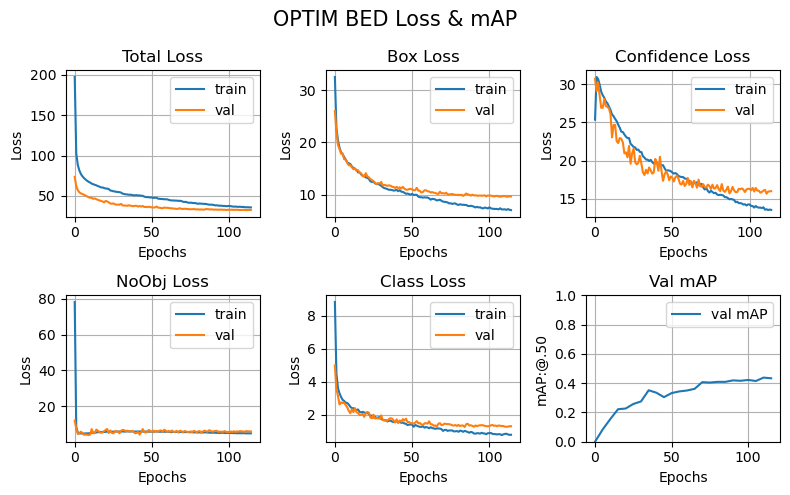

In [27]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(2,3, figsize=(8, 5))
fig.suptitle('OPTIM BED Loss & mAP', fontsize=15)

plt.subplot(2,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,2)
plt.plot(train_box_loss, label="train")
plt.plot(val_box_loss, label="val")
plt.title("Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,3)
plt.plot(train_confidence_loss, label="train")
plt.plot(val_confidence_loss, label="val")
plt.title("Confidence Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,4)
plt.plot(train_noobj_loss, label="train")
plt.plot(val_noobj_loss, label="val")
plt.title("NoObj Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,5)
plt.plot(train_class_loss, label="train")
plt.plot(val_class_loss, label="val")
plt.title("Class Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,6)
plt.plot(range(0, EPOCHS+1, 5), [0]+val_mAP, label="val mAP")
plt.title("Val mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_loss_ma.png")
plt.show()

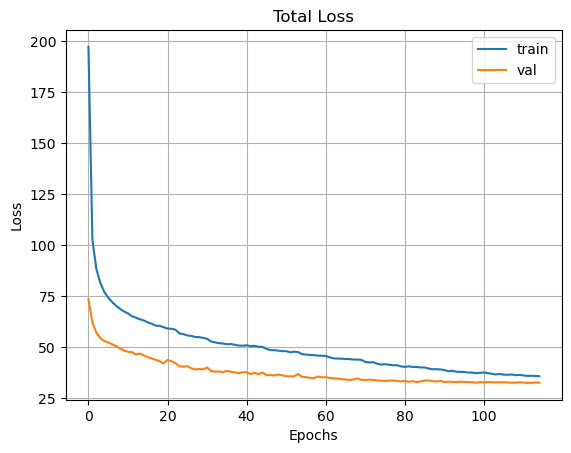

In [28]:
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "bed_loss_total.png")
plt.show()

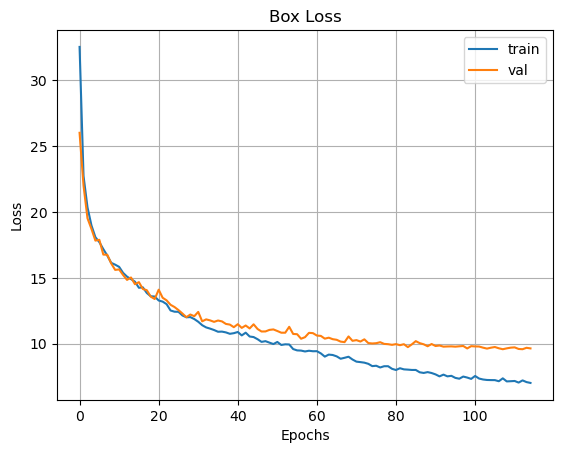

In [29]:
plt.plot(train_box_loss, label="train")
#plt.scatter(range(EPOCHS), train_box_loss)
plt.plot(val_box_loss, label="val")
#plt.scatter(range(EPOCHS), val_box_loss)
plt.title("Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "bed_loss_box.png")
plt.show()

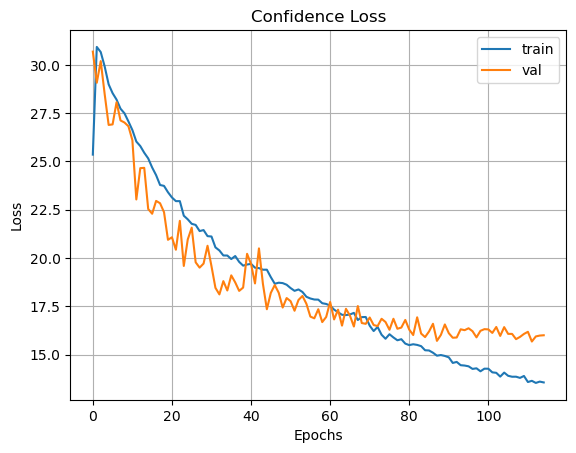

In [30]:
plt.plot(train_confidence_loss, label="train")
plt.plot(val_confidence_loss, label="val")
plt.title("Confidence Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "bed_loss_conf.png")
plt.show()

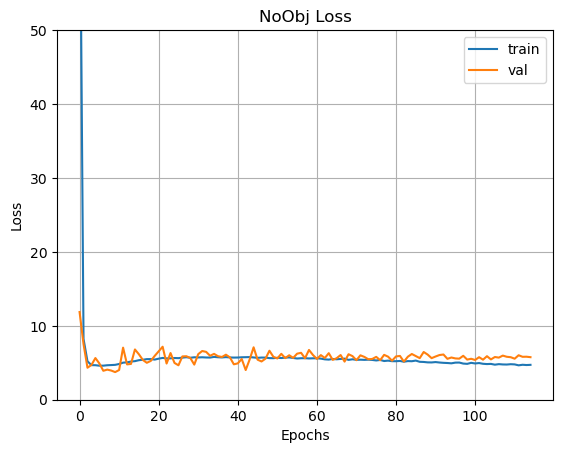

In [31]:
plt.plot(train_noobj_loss, label="train")
plt.plot(val_noobj_loss, label="val")
plt.title("NoObj Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0,50])
plt.legend()
plt.grid()
plt.savefig(log_path + "bed_loss_noobj.png")
plt.show()

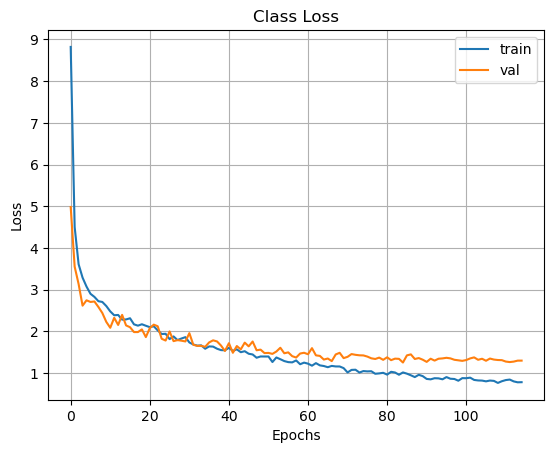

In [32]:
plt.plot(train_class_loss, label="train")
plt.plot(val_class_loss, label="val")
plt.title("Class Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "bed_loss_class.png")
plt.show()

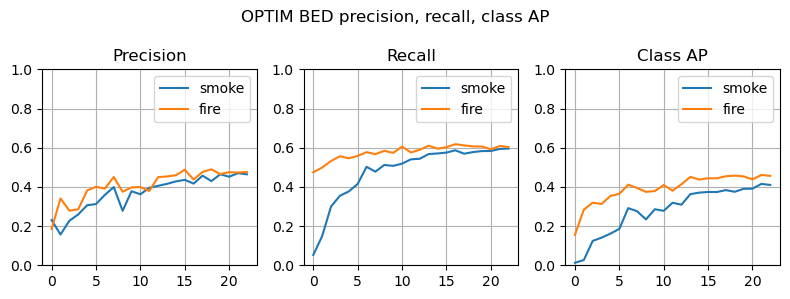

In [33]:
# val_class_AP
# val_class_precision
# val_class_recall

smoke_prec = []
fire_prec = []
for prec in val_class_precision:
    smoke_prec.append(prec[0])
    fire_prec.append(prec[1])

smoke_recall = []
fire_recall = []
for rec in val_class_recall:
    smoke_recall.append(rec[0])
    fire_recall.append(rec[1])

smoke_ap = []
fire_ap = []
for ap in val_class_AP:
    smoke_ap.append(ap[0])
    fire_ap.append(ap[1])

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
fig.suptitle('OPTIM BED precision, recall, class AP')

plt.subplot(1, 3, 1)
plt.plot(smoke_prec, label="smoke")
plt.plot(fire_prec, label="fire")
plt.title("Precision")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(smoke_recall, label="smoke")
plt.plot(fire_recall, label="fire")
plt.title("Recall")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(smoke_ap, label="smoke")
plt.plot(fire_ap, label="fire")
plt.title("Class AP")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig(log_path + "bed_precision_recall_classAP.png")
plt.show()

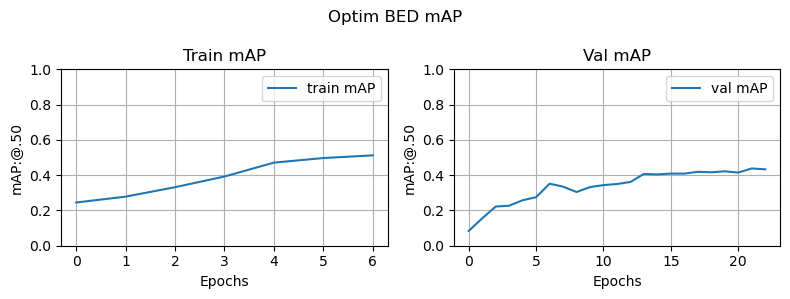

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Optim BED mAP')

plt.subplot(1,2,1)
plt.plot(train_mAP, label="train mAP")
plt.title("Train mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(val_mAP, label="val mAP")
plt.title("Val mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_mAP.png")
plt.show()

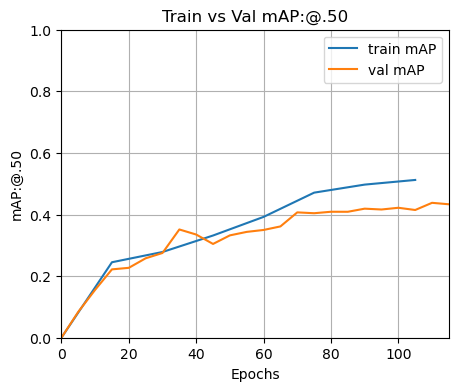

In [35]:
fig, axs = plt.subplots(figsize=(5, 4))

plt.plot(range(0, EPOCHS+1, 15), [0]+train_mAP, label="train mAP")
plt.plot(range(0, EPOCHS+1, 5), [0]+val_mAP, label="val mAP")
plt.title("Train vs Val mAP:@.50")
plt.xlim([0,EPOCHS])
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.savefig(log_path + "bed_mAP_together.png")
plt.show()